#### Approximation of Bartlett's Delta with deep stochastic optimization as the optimal solution to the Quadratic Hedging (QH) problem in the case of log-normal SABR dynamics.

- Let $S_t$ be the stock price and $C_t$ be the price of a contingent claim with maturity T.
- For simplicity we set interest rates to zero and we assume that there exists a risk neutral measure $Q$ under which both $S$ and $C$ are martingales.
-  Let $\theta$ be a strategy to hedge the payoff $C_T$.
-  Then we can write $$C_t = w+\int_0^t\theta_udS_u+L_t,$$
where $w$ is the initial capital and $L$ is the hedging error.
- In a complete market (Black-Scholes), the perfect hedging strategy $\theta^{\text{perf}}$ exists such that $L_T=0$,
- In an incomplete market such as SABR, there is no perfect hedging strategy.

### Quadratic Hedging
- aims to find the initial capital and the variance-optimal strategy $\theta^{VO}$ that solves
$$min_{\text{strategies}}E^{Q}\left[\left(C_T-w-\int_0^T\theta_udS_u\right)^2\right]$$

### SABR Model


- Let $C$ is the price process of a call option with maturity
$T$ and strike price $K$. To the call-price $C_t$ we can associate its (time-t) implied volatility $\Sigma_t$ and rewrite $C_t$ as
$$C_t = c_{\text{BS}}(T-t,S_t,\Sigma_t),$$
where $c_{\text{BS}}$ is the Black-Scholes price in dependence on time-to-maturity, underlying and implied
volatility.

- The SABR model with $\beta=1$ is given by,
$$dS_t=S_t\alpha_tdB_t$$
$$d\alpha_t=\frac{\eta}{2}\alpha_tdW_t,$$
where $d<B,W>=\rho dt$ for $\rho\in[-1,1]$.
- An aproximation $\hat{\Sigma}$ of the implied volatility for SABR is given by,
$$\hat{\Sigma}_t=\alpha_tf(Y_t),~~~Y_t=\frac{\eta}{\alpha_t}log\left(K/S_t\right),$$
where $f$ is given by
$$f(y)=\frac{y}{g(y)},~~~g(y)=-2log\left(\frac{\sqrt{1+\rho y+y^2/4}-\rho-y/2}{1-\rho}\right)$$

#### Bartlett's Delta
it is shown in ([this paper](https://arxiv.org/abs/2207.13573)) that the Bartlett's Delta (with $\Sigma$ replaced by $\hat{\Sigma}$),
$$\theta_t^{\text{Bartlett}}=\hat{\text{Delta}}_t+\hat{\text{Vega}}_t\left(\frac{\rho}{2\eta}\frac{\partial \hat{\Sigma}_t}{\partial\alpha}+\frac{\partial\hat{\Sigma}_t}{\partial S}\right)$$
is the optimal solution for the above QH problem under the SABR model for the stock dynamics.

### SABR model specification

In [ ]:
import numpy as np
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import random
from scipy.stats import norm
import matplotlib.pyplot as plt

In [ ]:
""" Utility Functions """

random.seed(1)

def brownian_sim(num_path, num_period, mu, std, init_p, dt):
    z = np.random.normal(size=(num_path, num_period))

    a_price = np.zeros((num_path, num_period))
    a_price[:, 0] = init_p

    for t in range(num_period - 1):
        a_price[:, t + 1] = a_price[:, t] * np.exp(
            (mu - (std ** 2) / 2) * dt + std * np.sqrt(dt) * z[:, t]
        )
    return a_price


# BSM Call Option Pricing Formula & BS Delta formula
# T here is time to maturity
def bs_call(iv, T, S, K, r, q):
    d1 = (np.log(S / K) + (r - q + iv * iv / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    bs_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    bs_delta = np.exp(-q * T) * norm.cdf(d1)
    return bs_price, bs_delta


def get_sim_path(M, freq, np_seed, num_sim):
    """ Return simulated data: a tuple of three arrays
        M: initial time to maturity
        freq: trading freq in unit of day, e.g. freq=2: every 2 day; freq=0.5 twice a day;
        np_seed: numpy random seed
        num_sim: number of simulation path
        1) asset price paths (num_path x num_period)
        2) option price paths (num_path x num_period)
        3) delta (num_path x num_period)
    """
    # set the np random seed
    # np.random.seed(np_seed)

    # Trading Freq per day; passed from function parameter
    # freq = 2

    # Annual Trading Day
    T = 250

    # Simulation Time Step
    dt = 0.004 * freq

    # Option Day to Maturity; passed from function parameter
    # M = 60

    # Number of period
    num_period = int(M / freq)

    # Number of simulations; passed from function parameter
    # num_sim = 1000000

    # Annual Return
    mu = 0.05

    # Annual Volatility
    vol = 0.2

    # Initial Asset Value
    S = 100

    # Option Strike Price
    K = 100

    # Annual Risk Free Rate
    r = 0

    # Annual Dividend
    q = 0

    # asset price 2-d array
    print("1. generate asset price paths")
    a_price = brownian_sim(num_sim, num_period + 1, mu, vol, S, dt)

    # time to maturity "rank 1" array: e.g. [M, M-1, ..., 0]
    ttm = np.arange(M, -freq, -freq)

    # BS price 2-d array and bs delta 2-d array
    print("2. generate BS price and delta")
    bs_price, bs_delta = bs_call(vol, ttm / T, a_price, K, r, q)

    print("simulation done!")

    return a_price, bs_price, bs_delta


def sabr_sim(num_path, num_period, mu, std, init_p, dt, rho, beta, volvol):
    qs = np.random.normal(size=(num_path, num_period))
    qi = np.random.normal(size=(num_path, num_period))
    qv = rho * qs + np.sqrt(1 - rho * rho) * qi

    vol = np.zeros((num_path, num_period))
    vol[:, 0] = std

    a_price = np.zeros((num_path, num_period))
    a_price[:, 0] = init_p

    for t in range(num_period - 1):
        gvol = vol[:, t] * (a_price[:, t] ** (beta - 1))
        a_price[:, t + 1] = a_price[:, t] * np.exp(
            (mu - (gvol ** 2) / 2) * dt + gvol * np.sqrt(dt) * qs[:, t]
        )
        vol[:, t + 1] = vol[:, t] * np.exp(
            -volvol * volvol * 0.5 * dt + volvol * qv[:, t] * np.sqrt(dt)
        )

    return a_price, vol


def sabr_implied_vol(vol, T, S, K, r, q, beta, volvol, rho):

    F = S * np.exp((r - q) * T)
    x = (F * K) ** ((1 - beta) / 2)
    y = (1 - beta) * np.log(F / K)
    A = vol / (x * (1 + y * y / 24 + y * y * y * y / 1920))
    B = 1 + T * (
        ((1 - beta) ** 2) * (vol * vol) / (24 * x * x)
        + rho * beta * volvol * vol / (4 * x)
        + volvol * volvol * (2 - 3 * rho * rho) / 24
    )
    Phi = (volvol * x / vol) * np.log(F / K)
    Chi = np.log((np.sqrt(1 - 2 * rho * Phi + Phi * Phi) + Phi - rho) / (1 - rho))

    SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)

    return SABRIV


def bartlett(sigma, T, S, K, r, q, ds, beta, volvol, rho):

    dsigma = ds * volvol * rho / (S ** beta)

    vol1 = sabr_implied_vol(sigma, T, S, K, r, q, beta, volvol, rho)
    vol2 = sabr_implied_vol(sigma + dsigma, T, S + ds, K, r, q, beta, volvol, rho)

    bs_price1, _ = bs_call(vol1, T, S, K, r, q)
    bs_price2, _ = bs_call(vol2, T, S+ds, K, r, q)

    b_delta = (bs_price2 - bs_price1) / ds

    return b_delta

def bs_call(iv, T, S, K, r, q):
    d1 = (np.log(S / K) + (r - q + iv * iv / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    bs_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    bs_delta = np.exp(-q * T) * norm.cdf(d1)
    return bs_price, bs_delta




In [ ]:
def get_sim_path_sabr(S_0, mu, vol, r, K, M, freq, num_sim):
    """ Return simulated data: a tuple of four arrays
        S:Initial Asset Value
        mu: Annual Return
        vol:  Annual Volatility
        r: Annual Risk Free Rate
        K: Option Strike Price
        M: time to maturity
        freq: trading freq in unit of day, e.g. freq=2: every 2 day; freq=0.5 twice a day;
        np_seed: numpy random seed
        num_sim: number of simulation path
        1) asset price paths (num_path x num_period)
        2) option price paths (num_path x num_period)
        3) bs delta (num_path x num_period)
        4) bartlett delta (num_path x num_period)
    """
    # set the np random seed
    # np.random.seed(1234)

    # Annual Trading Day
    T = 252

    # Simulation Time Step
    dt = 0.004 * freq

    # Option Day to Maturity; passed from function parameter
    # M = 60

    # Number of period
    num_period = int(M / freq)

    # Annual Dividend
    q = 0

    # SABR parameters
    beta = 1
    rho = 0.96
    volvol = 0.95
    ds = 0.001

    # asset price 2-d array; sabr_vol
    #print("1. generate asset price paths (sabr)")
    a_price, sabr_vol = sabr_sim(
        num_sim, num_period + 1, mu, vol, S_0, dt, rho, beta, volvol
    )

    # time to maturity "rank 1" array: e.g. [M, M-1, ..., 0]
    ttm = np.arange(M, -freq, -freq)

    # BS price 2-d array and bs delta 2-d array
    #print("2. generate BS price, BS delta, and Bartlett delta")

    # sabr implied vol
    implied_vol = sabr_implied_vol(
        sabr_vol, ttm / T, a_price, K, r, q, beta, volvol, rho
    )

    bs_price, bs_delta = bs_call(implied_vol, ttm / T, a_price, K, r, q)

    bartlett_delta = bartlett(sabr_vol, ttm / T, a_price, K, r, q, ds, beta, volvol, rho)

    #print("simulation done!")

    return a_price, bs_price, bs_delta, bartlett_delta

### Setting up the Computation Graph

In [ ]:
#initialization of parameters
def weights_init_uniform_rule(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('nn.Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)

### Networks
class Phi_Dot_0(nn.Module):
    def __init__(self):
        super(Phi_Dot_0, self).__init__()
        self.phi_Dot_0 = nn.Linear(1, 1)
    def forward(self, x):
        return self.phi_Dot_0(x)


class RL_Net(nn.Module):
    def __init__(self,INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM):
        super(RL_Net, self).__init__()
        self.input_dim = INPUT_DIM
        self.output_dim = OUTPUT_DIM
        self.hidden_dim = HIDDEN_DIM
        current_dim = self.input_dim
        self.layers = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.droupout = nn.ModuleList() #drop out layer for regularization
        for hdim in self.hidden_dim:
            self.layers.append(nn.Linear(int(current_dim), int(hdim)))
            self.bn.append(nn.BatchNorm1d(int(hdim)))
            self.droupout.append(nn.Dropout(0.25)) # add a dropout layer
            current_dim = hdim
        self.layers.append(nn.Linear(int(current_dim), int(self.output_dim)))
    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x.float())
            x = self.bn[i](x)
            x = F.relu(x)
        out = self.layers[-1](x)
        return out


In [ ]:
def Mean_Utility(S,C,D,PHI,PHI_dot,LAM,kappa,TIME,time_step,n_samples):
    """Calculate the average loss for the batch
    S: Stock prices (BATCH_SIZE,TIME_STEP)
    C: Option prices (BATCH_SIZE,TIME_STEP)
    D: Option Deltas (BATCH_SIZE,TIME_STEP)
    PHI: Hedging strategy(BATCH_SIZE,TIME_STEP+1)
    PHI_dot: rebalancing rate(BATCH,TIME_STEP)
    LAM: Risk aversion parameter
    TIME: Time horizon T"""
    delta_t = TIME/time_step
    cf_mat = torch.zeros((n_samples,time_step+1)) #cash flow matrix
    cf_mat[:,0] = -kappa*torch.abs(torch.mul(S[:,0],PHI[:,0]))
    for i in torch.arange(1,time_step):
        cf_mat[:,i] = PHI[:,i]*(S[:,i]-S[:,i-1])-kappa*torch.abs(S[:,i]*PHI_dot[:,i]*delta_t)
    cf_mat[:,-1] = cf_mat[:,-1]-kappa*torch.abs(S[:,-1]*PHI[:,-1])
    loss_mat = (torch.sum(cf_mat,dim=1)-C[:,-1])**2 #loss_mat.shape =(n_samples,)
    return torch.mean(loss_mat), cf_mat

In [ ]:
def calculate_Bartlett_pnl(S,C,D,kappa,TIME,time_step,n_samples):
    """Calculate the average loss for the batch
    S: Stock prices (BATCH_SIZE,TIME_STEP)
    C: Option prices (BATCH_SIZE,TIME_STEP)
    D: Option Bartlett Deltas (BATCH_SIZE,TIME_STEP)
    # PHI: Hedging strategy(BATCH_SIZE,TIME_STEP+1)- only PHI[:,0] used
    LAM: Risk aversion parameter
    TIME: Time horizon T"""


    # PHI = torch.zeros((n_samples, time_step + 1))
    # PHI_0=torch.ones(n_samples)*PHI_INITIAL
    # PHI[:,0] = PHI_0.reshape((-1,))
    # PHI_dot = torch.zeros((n_samples, time_step ))
    delta_t = TIME/time_step
    cf_mat = torch.zeros((n_samples,time_step+1))
    cf_mat[:,0] = -kappa*torch.abs(torch.mul(S[:,0],D[:,0]))
    print(cf_mat.shape)
    for i in torch.arange(1,time_step):
        cf_mat[:,i] = torch.mul(D[:,i-1],(S[:,i]-S[:,i-1]))-kappa*torch.abs(S[:,i]*(D[:,i]-D[:,i-1]))
    cf_mat[:,-1] = cf_mat[:,-1]-kappa*torch.abs(S[:,-1]*D[:,-1])
    pnl_mat = torch.sum(cf_mat,dim=1)-C[:,-1]
    return pnl_mat

In [ ]:
def TRAIN_Utility(S_0,vol,mu,ir,K,PHI_INITIAL,LAM,kappa,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,LR_Utility = 0.001,saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0):

    """
    n_samples: path size of the Brownian Motion
    time_step: discretization step
    LR_Utility: initial learning rate
    saving: list, to indicate at which epoch should have the models be saved to the path_temp
         saving=0 means no saving
    LR_Adjust: a dictoinary in which the value is the absolute DECAY,
          and the key is the epoch corresponding to the updated learning rate
    OPT_Utility: "ADAM" or "SGD"
    """
    model_list_Utility = []
    i = 0
    while i <= time_step:
        model = RL_Net(INPUT_DIM_Utility,OUTPUT_DIM,HIDDEN_DIM_Utility)
        model.apply(weights_init_uniform_rule)
        model_list_Utility.append(model)
        i += 1
    if OPT_Utility=="SGD":
        optimizer_Utility = torch.optim.SGD((par for model in model_list_Utility
                        for par in model.parameters()),
                                lr=LR_Utility)
    if OPT_Utility=="ADAM":
        optimizer_Utility = torch.optim.Adam((par for model in model_list_Utility
                        for par in model.parameters()),
                        lr=LR_Utility, betas=(0.9, 0.99))

    loss_arr_Utility = []
    PHI_0=torch.ones(n_samples)*PHI_INITIAL
    DUMMY_1 = torch.ones(n_samples).reshape((n_samples, 1))
    for epoch in tqdm(range(EPOCH)):
        ### tuning the learning rate
        if epoch in LR_Adjust.keys():
            DECAY = LR_Adjust[epoch]
            for g in optimizer_Utility.param_groups:
                g['lr'] = LR_Utility*DECAY

        S, C, D,BD = get_sim_path_sabr(S_0, mu, vol, ir, K, TIME, int(TIME/time_step), n_samples)
        S = torch.from_numpy(S)
        C = torch.from_numpy(C)
        D = torch.from_numpy(D)
        BD = torch.from_numpy(BD)
        optimizer_Utility.zero_grad()
        PHI = torch.zeros((n_samples, time_step + 1))

        PHI[:,0] = PHI_0.reshape((-1,))

        PHI_dot = torch.zeros((n_samples, time_step ))

        for t in range(time_step):#t=0,...,time_step-1, X_utility.shape =(batch_SIZE,TIME_STEP)
            t_tensor=t/time_step*TIME*torch.ones(n_samples).reshape(-1,1)
            x_Utility=torch.cat((t_tensor,S[:,t].reshape(-1,1),C[:,t].reshape(-1,1),BD[:,t].reshape(-1,1),PHI[:,t].reshape(-1,1)),dim=1)
            X_Utility = x_Utility.float()
            PHI_dot[:,t] = model_list_Utility[t](x_Utility).reshape(-1,)
            PHI[:,(t+1)] = PHI[:,t].reshape(-1)+PHI_dot[:,(t)].reshape(-1)*TIME/time_step
        loss_Utility, _ = Mean_Utility(S,C,D,PHI,PHI_dot,LAM,kappa,TIME,time_step,n_samples)
        loss_arr_Utility.append(loss_Utility.data)
        loss_Utility.backward()   #compute gradient
        optimizer_Utility.step()  #update NN weights
        if np.isinf(loss_Utility.data.cpu().numpy()) or np.isnan(loss_Utility.data.cpu().numpy()):
            print("\nFAIL")
            break
        ### saving
        path_Q = './models/'
        if saving:
            if epoch%100==0:
                for i,model in enumerate(model_list_Utility):
                      torch.save(model.state_dict(),path_Q+'Utility_para{}.pkl'.format(i))
                torch.save(loss_arr_Utility,path_Q+"Utility_LOSS_arr.pt")
                torch.save(optimizer_Utility.state_dict(),path_Q+"Utility_optimizer.pt")
                print("\n saving models after {} Epochs".format(epoch+1))
    result={
        'loss':loss_arr_Utility,
        'model_list':model_list_Utility
      }
    return(result)



In [ ]:
S_0 =100
K =100
vol = 0.20/np.sqrt(252)
ir = 0.0
mu = 0.0
PHI_INITIAL = 0.0
LAM = 0.1
TIME = 30
EPOCH =50
n_samples = 100000
time_step = 30
LR_Utility = 0.001
INPUT_DIM_Utility = 5 #The dimension of the input is 5:(t,S_t,C_t,Bartlett_Delta_t,phi_t)
OUTPUT_DIM = 1
HIDDEN_DIM_Utility = [64,128,64]
kappa = 0

In [ ]:
result = TRAIN_Utility(S_0,vol,mu,ir,K,PHI_INITIAL,LAM,kappa,TIME,EPOCH,n_samples,time_step,HIDDEN_DIM_Utility,LR_Utility,saving=0,LR_Adjust=dict(),OPT_Utility="ADAM",SEED_Utility1=0,SEED_Utility2=0)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: divide by zero encountered in true_divide
100%|██████████| 50/50 [17:29<00:00, 21.00s/it]


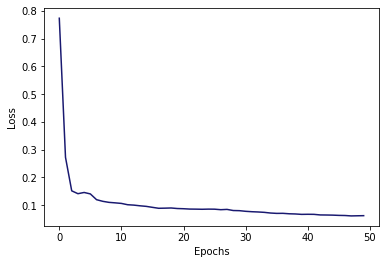

In [ ]:
plt.plot(result['loss'],color='midnightblue')
plt.xlabel('Epochs')
plt.ylabel('Loss');

### Deep hedge: Out of Sample Performance:

- Simulate N_sample episode
- Rollout the trained agent
- Calculate the hedging cost on each path
- create a histogram of hedging cost

In [ ]:
model_list_Utility = result['model_list']
n_samples =1000
S, C, D,BD = get_sim_path_sabr(S_0, mu, vol, ir, K, TIME, int(TIME/time_step), n_samples)
S = torch.from_numpy(S)
C = torch.from_numpy(C)
D = torch.from_numpy(D)
BD = torch.from_numpy(BD)
PHI = torch.zeros((n_samples, time_step + 1))
PHI_0 = torch.ones(n_samples)*PHI_INITIAL
PHI[:,0] = PHI_0.reshape((-1,))

PHI_dot = torch.zeros((n_samples, time_step ))

for t in range(time_step):#t=0,...,time_step-1, X_utility.shape =(batch_SIZE,TIME_STEP)
    t_tensor=t/time_step*TIME*torch.ones(n_samples).reshape(-1,1)
    x_Utility=torch.cat((t_tensor,S[:,t].reshape(-1,1),C[:,t].reshape(-1,1),D[:,t].reshape(-1,1),PHI[:,t].reshape(-1,1)),dim=1)
    X_Utility = x_Utility.float()
    PHI_dot[:,t] = model_list_Utility[t](x_Utility).reshape(-1,)
    PHI[:,(t+1)] = PHI[:,t].reshape(-1)+PHI_dot[:,(t)].reshape(-1)*TIME/time_step

_,cf_mat  = Mean_Utility(S,C,D,PHI,PHI_dot,LAM,kappa,TIME,time_step,n_samples)
deep_pnl = torch.sum(cf_mat,dim=1)-C[:,-1]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:150: RuntimeWarning: divide by zero encountered in true_divide


### Bartlett Delta PnL

In [ ]:
bartlett_delta_pnl = calculate_Bartlett_pnl(S,C,BD,kappa,TIME,time_step,n_samples)

torch.Size([1000, 31])


### Black-Scholes Delta PnL

In [ ]:
bs_delta_pnl = calculate_Bartlett_pnl(S,C,D,kappa,TIME,time_step,n_samples)

torch.Size([1000, 31])


### Deep Hedge vs Bartlett Delta vs BS Delta

Average Deep Hedging cost: 0.17851559989362584
Average Bartlett Delta Hedging cost: 0.1777342423761599
Average Black-Scholes Delta Hedging cost: 0.1781598973928355


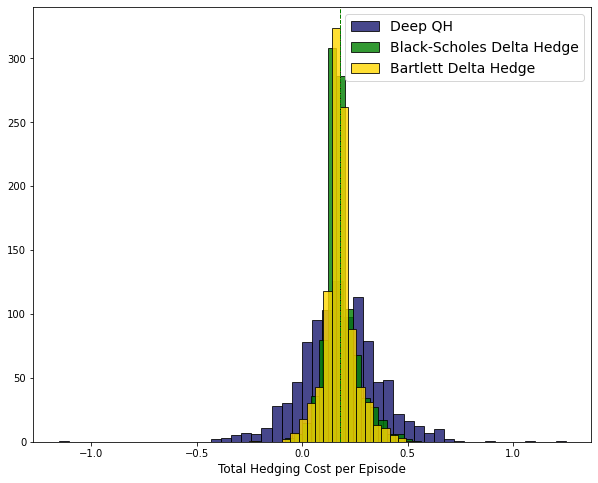

In [ ]:
plt.figure(figsize=(10,8))
plt.hist(-deep_pnl.detach().numpy(),bins=50,color = 'midnightblue',edgecolor='black',alpha =0.8,label='Deep QH')
plt.hist(-bs_delta_pnl.detach().numpy(),bins=20,color = 'green',edgecolor='black',alpha =0.8,label = 'Black-Scholes Delta Hedge')
plt.hist(-bartlett_delta_pnl.detach().numpy(),bins=20,color = 'gold',edgecolor='black',alpha =0.8,label = 'Bartlett Delta Hedge')
plt.axvline(-deep_pnl.detach().numpy().mean(), color='midnightblue', linestyle='dashed', linewidth=1)
plt.axvline(-bartlett_delta_pnl.detach().numpy().mean(), color='gold', linestyle='dashed', linewidth=1)
plt.axvline(-bs_delta_pnl.detach().numpy().mean(), color='green', linestyle='dashed', linewidth=1)
plt.xlabel('Total Hedging Cost per Episode',fontsize=12)
plt.legend(fontsize=14)
print('Average Deep Hedging cost: {}'.format(-deep_pnl.detach().numpy().mean()))
print('Average Bartlett Delta Hedging cost: {}'.format(-bartlett_delta_pnl.detach().numpy().mean()))
print('Average Black-Scholes Delta Hedging cost: {}'.format(-bs_delta_pnl.detach().numpy().mean()));

In [ ]:
type(BD.detach().numpy())

numpy.ndarray

## Inspect the paths

### Bartlett vs. Deep QH

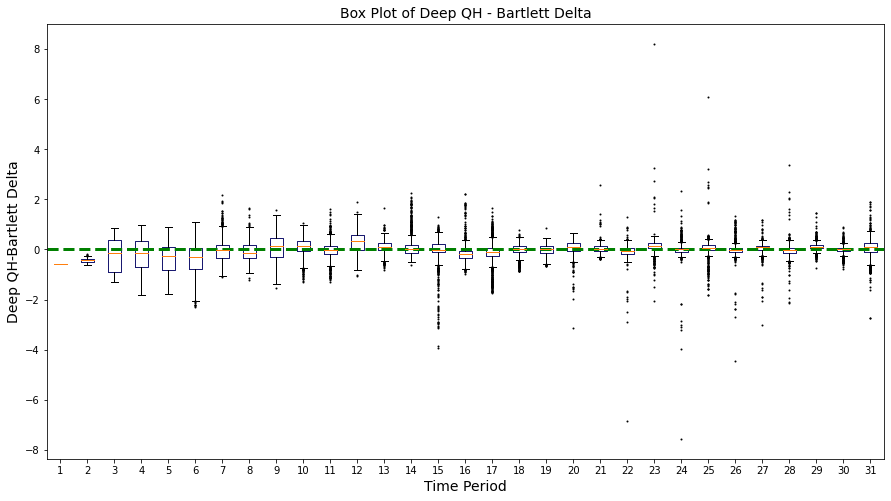

In [ ]:
plt.figure(figsize=(15,8))
bp = plt.boxplot(PHI.detach().numpy()-BD.detach().numpy(),flierprops={'marker': 'o', 'markersize': 1, 'markerfacecolor': 'midnightblue'})
for box in bp['boxes']:
    # change outline color
    box.set(color='midnightblue', linewidth=1)
plt.axhline(y=0.0, color='green', linestyle='dashed', linewidth=3)
# plt.legend(fontsize=14)
plt.title('Box Plot of Deep QH - Bartlett Delta',fontsize=14)
plt.xlabel('Time Period',fontsize=14)
plt.ylabel('Deep QH-Bartlett Delta',fontsize=14)
plt.ylim((15,55))
plt.show()

### Bartlett vs. Delta

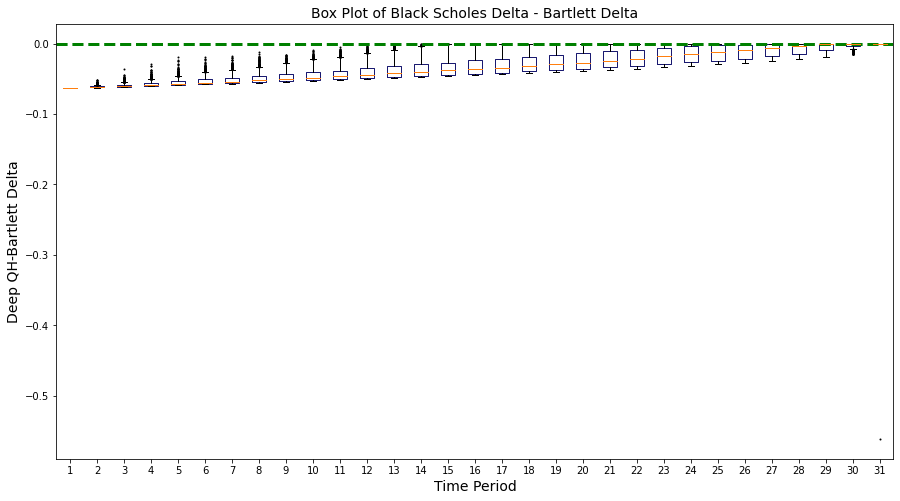

In [ ]:
plt.figure(figsize=(15,8))
bp = plt.boxplot(D.detach().numpy()-BD.detach().numpy(),flierprops={'marker': 'o', 'markersize': 1, 'markerfacecolor': 'midnightblue'})
for box in bp['boxes']:
    # change outline color
    box.set(color='midnightblue', linewidth=1)
plt.axhline(y=0.0, color='green', linestyle='dashed', linewidth=3)
# plt.legend(fontsize=14)
plt.title('Box Plot of Black Scholes Delta - Bartlett Delta',fontsize=14)
plt.xlabel('Time Period',fontsize=14)
plt.ylabel('Deep QH-Bartlett Delta',fontsize=14)
#plt.ylim((15,55))
plt.show()

### How to increase the gap between Bartlett delta and Black-Scholes Delta
### This is to show that Deep QH outperform Black Scholes delta and approximate Bartlett